In [1]:
# pip install ipykernel ipywidgets torch pandas datasets transformers[torch] tensorboard astartes matplotlib numpy
# clone then run python setup.py install: https://github.com/NVIDIA/apex.git

In [2]:
from pathlib import Path

In [3]:
_base = "DeepChem/ChemBERTa-77M-MLM"
_tuning_data = Path("../../data/krasnov/bigsoldb_chemprop_nonaq.csv")

In [4]:
from astartes import train_test_split
import pandas as pd
from datasets import Dataset

In [5]:
df = pd.read_csv(_tuning_data)
studies_train, studies_val = train_test_split(pd.unique(df["source"]), random_state=1, train_size=0.90, test_size=0.10)
train_indexes = df.index[df["source"].isin(studies_train)].tolist()
val_indexes = df.index[df["source"].isin(studies_val)].tolist()
train_dataset = Dataset.from_pandas(df.iloc[train_indexes])
val_dataset = Dataset.from_pandas(df.iloc[val_indexes])

In [6]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer

In [7]:
def tokenize_function(examples, tokenizer):
    inputs = [s1 + '.' + s2 + ' ' + str(temp) for s1, s2, temp in zip(examples["solute_smiles"], examples["solvent_smiles"], examples["temperature"])]
    return tokenizer(inputs, padding="max_length", truncation=True)

def preprocess_labels(example):
    example["labels"] = float(example["logS"])
    return example


In [8]:
tokenizer = AutoTokenizer.from_pretrained(_base)
model = AutoModelForSequenceClassification.from_pretrained(_base, num_labels=1)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
train_dataset = train_dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True).map(preprocess_labels)
val_dataset = val_dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True).map(preprocess_labels)

Map:   0%|          | 0/37190 [00:00<?, ? examples/s]

Map:   0%|          | 0/37190 [00:00<?, ? examples/s]

Map:   0%|          | 0/4534 [00:00<?, ? examples/s]

Map:   0%|          | 0/4534 [00:00<?, ? examples/s]

In [10]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    report_to=["tensorboard"],
)

In [11]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")  # Extract labels
        outputs = model(**inputs)
        logits = outputs.logits.squeeze(-1)  # Ensure shape compatibility
        loss_fct = torch.nn.MSELoss()  # Mean Squared Error for regression
        loss = loss_fct(logits, labels)        
        return (loss, outputs) if return_outputs else loss

In [12]:
# Trainer setup
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    processing_class=tokenizer,
)

In [13]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.328900,1.201037
2,0.274700,1.200140
3,0.425400,1.219104
4,0.166700,1.203101
5,0.191900,1.184249


TrainOutput(global_step=23245, training_loss=0.32612589144865706, metrics={'train_runtime': 9055.6231, 'train_samples_per_second': 20.534, 'train_steps_per_second': 2.567, 'total_flos': 1713304479590400.0, 'train_loss': 0.32612589144865706, 'epoch': 5.0})

In [14]:
# Save final model
trainer.save_model("./solubility_llm")
tokenizer.save_pretrained("./solubility_llm")

('./solubility_llm/tokenizer_config.json',
 './solubility_llm/special_tokens_map.json',
 './solubility_llm/vocab.json',
 './solubility_llm/merges.txt',
 './solubility_llm/added_tokens.json',
 './solubility_llm/tokenizer.json')

In [49]:
def predict(smiles_1, smiles_2, temperature):
    model.eval()
    inputs = tokenizer(smiles_1 + "." + smiles_2 + " " + str(temperature), return_tensors="pt", padding="max_length", truncation=True).to(model.device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.logits.item()

# Example usage
print(predict("CCO", "CCCC", 25.0))

0.7916637063026428


In [50]:
_reload_dir = "solubility_llm"
tokenizer = AutoTokenizer.from_pretrained(_reload_dir)
model = AutoModelForSequenceClassification.from_pretrained(_reload_dir, num_labels=1)

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [52]:
def parity_plot(truth, prediction, title, out_fpath):
    plt.clf()
    plt.scatter(truth, prediction, alpha=0.1)
    plt.xlabel("truth")
    plt.ylabel("prediction")
    min_val = min(np.min(truth), np.min(prediction)) - 0.5
    max_val = max(np.max(truth), np.max(prediction)) + 0.5
    plt.plot([min_val, max_val], [min_val, max_val], color="black", linestyle="-")
    plt.plot([min_val, max_val], [min_val + 1, max_val + 1], color="red", linestyle="--", alpha=0.25)
    plt.plot([min_val, max_val], [min_val - 1, max_val - 1], color="red", linestyle="--", alpha=0.25)
    plt.ylim(min_val, max_val)
    plt.xlim(min_val, max_val)
    r, _ = pearsonr(truth, prediction)
    mse = mean_squared_error(truth, prediction)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(truth, prediction)
    wn_07 = np.count_nonzero(np.abs(truth - prediction) <= 0.7) / len(prediction)
    wn_1 = np.count_nonzero(np.abs(truth - prediction) <= 1.0) / len(prediction)
    stat_str = (
        f" - Pearson's r: {r:.4f}\n - MAE: {mae:.4f}\n - MSE: {mse:.4f}\n - RMSE: {rmse:.4f}\n - W/n 0.7: {wn_07:.4f}\n - W/n 1.0: {wn_1:.4f}"
    )
    plt.text(min_val, max_val - 0.1, stat_str, horizontalalignment="left", verticalalignment="top")
    plt.title(title)
    plt.savefig(out_fpath)
    plt.show()

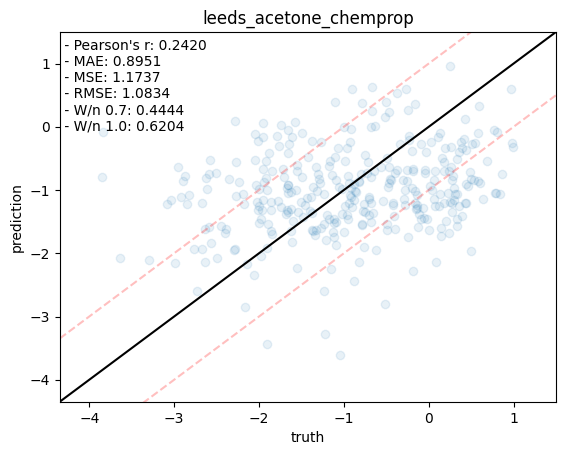

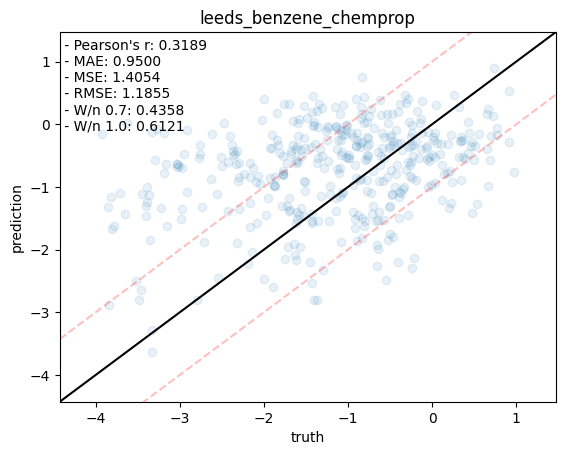

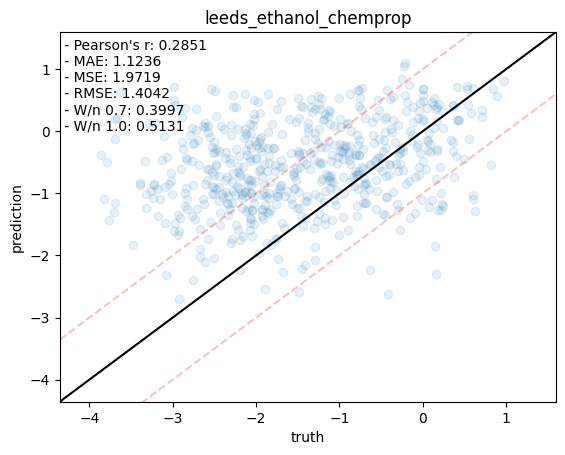

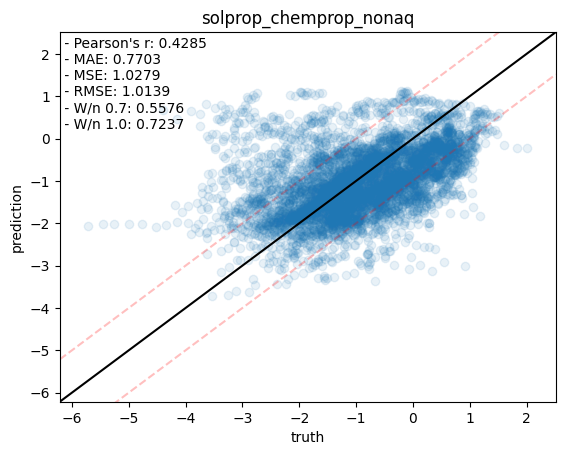

In [53]:
for holdout_fpath in (
    Path("boobier/leeds_acetone_chemprop.csv"),
    Path("boobier/leeds_benzene_chemprop.csv"),
    Path("boobier/leeds_ethanol_chemprop.csv"),
    Path("vermeire/solprop_chemprop_nonaq.csv"),
):
    # load the holdout data
    df = pd.read_csv(Path("../../data") / holdout_fpath, index_col=0)
    pred = df.apply(lambda row: predict(row["solute_smiles"], row["solvent_smiles"], row["temperature"]), axis=1)
    out = pd.DataFrame(pred, columns=["logS_pred"], index=np.arange(len(df)))
    out.insert(0, "solute_smiles", df["solute_smiles"].tolist())
    out.insert(1, "solvent_smiles", df["solvent_smiles"].tolist())
    out.insert(2, "logS_true", df["logS"].tolist())
    out.insert(3, "temperature", df["temperature"].tolist())
    out.to_csv((holdout_fpath.stem + "_predictions.csv"))
    parity_plot(out["logS_true"], out["logS_pred"], holdout_fpath.stem, f"{holdout_fpath.stem}_parity.png")
